<a href="https://colab.research.google.com/github/finesketch/deep_learning/blob/main/4.%20Sequences%2C%20Time%20Series%20and%20Prediction/Course4_Part4_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.0


In [2]:
def plot_series(time, series, format='-', start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-12-19 22:55:23--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2020-12-19 22:55:23 (4.65 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



1981-01-01
20.7


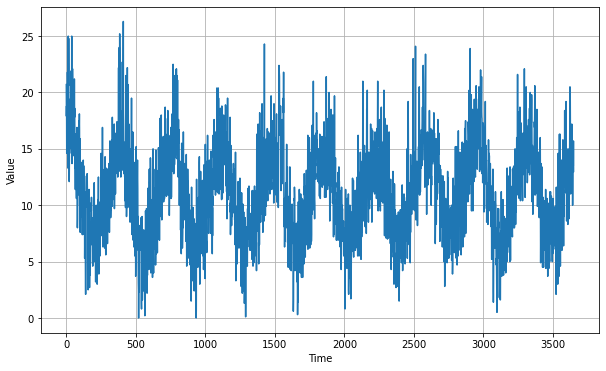

In [9]:
import csv

time_steps = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    if step == 0:
      print(str(row[0]))
      print(str(float(row[1])))
    temps.append(float(row[1]))
    
    time_steps.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_steps)
plt.figure(figsize=(10,6))
plot_series(time, series)


In [10]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [16]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)

In [32]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 64
batch_size = 256

In [17]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)


In [18]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None,1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 7s 308ms/step - loss: 27.3818 - mae: 27.8785
Epoch 2/100
10/10 [==============================] - 3s 310ms/step - loss: 26.7161 - mae: 27.2125
Epoch 3/100
10/10 [==============================] - 3s 299ms/step - loss: 26.0366 - mae: 26.5331
Epoch 4/100
10/10 [==============================] - 3s 301ms/step - loss: 25.5797 - mae: 26.0761
Epoch 5/100
10/10 [==============================] - 3s 309ms/step - loss: 24.8554 - mae: 25.3516
Epoch 6/100
10/10 [==============================] - 3s 299ms/step - loss: 23.9739 - mae: 24.4697
Epoch 7/100
10/10 [==============================] - 3s 303ms/step - loss: 22.7876 - mae: 23.2831
Epoch 8/100
10/10 [==============================] - 3s 301ms/step - loss: 21.9977 - mae: 22.4935
Epoch 9/100
10/10 [==============================] - 3s 304ms/step - loss: 20.9306 - mae: 21.4261
Epoch 10/100
10/10 [==============================] - 3s 300ms/step - loss: 19.7895 - mae: 20.2847
Epoch 11/100
10/10 

(1e-08, 0.0001, 0.0, 60.0)

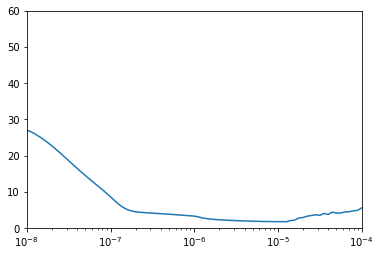

In [19]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 60])

In [20]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [21]:
train_set = windowed_dataset(x_train, window_size=64, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None,1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])

history = model.fit(train_set, epochs=150)

Epoch 1/150
20/20 [==============================] - 7s 173ms/step - loss: 35.1337 - mae: 35.6294
Epoch 2/150
20/20 [==============================] - 4s 177ms/step - loss: 3.9124 - mae: 4.3855
Epoch 3/150
20/20 [==============================] - 4s 169ms/step - loss: 2.3397 - mae: 2.7981
Epoch 4/150
20/20 [==============================] - 4s 177ms/step - loss: 1.9693 - mae: 2.4242
Epoch 5/150
20/20 [==============================] - 4s 169ms/step - loss: 1.9038 - mae: 2.3588
Epoch 6/150
20/20 [==============================] - 3s 165ms/step - loss: 1.8813 - mae: 2.3346
Epoch 7/150
20/20 [==============================] - 4s 175ms/step - loss: 1.8632 - mae: 2.3173
Epoch 8/150
20/20 [==============================] - 4s 173ms/step - loss: 1.8634 - mae: 2.3166
Epoch 9/150
20/20 [==============================] - 4s 180ms/step - loss: 1.8456 - mae: 2.2988
Epoch 10/150
20/20 [==============================] - 4s 176ms/step - loss: 1.8237 - mae: 2.2762
Epoch 11/150
20/20 [=================

In [33]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

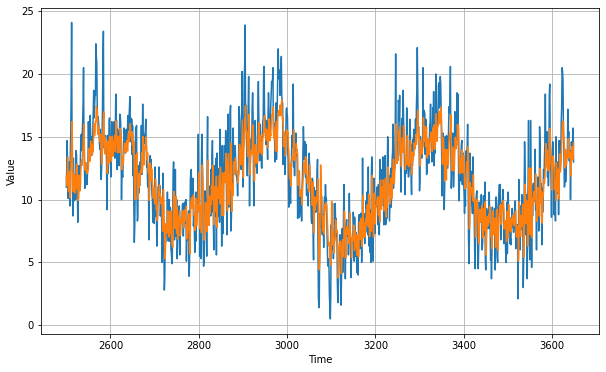

In [34]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [35]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.8265504

In [36]:
print(rnn_forecast)

[11.849746 11.088768 11.849623 ... 13.172349 13.483495 14.50693 ]


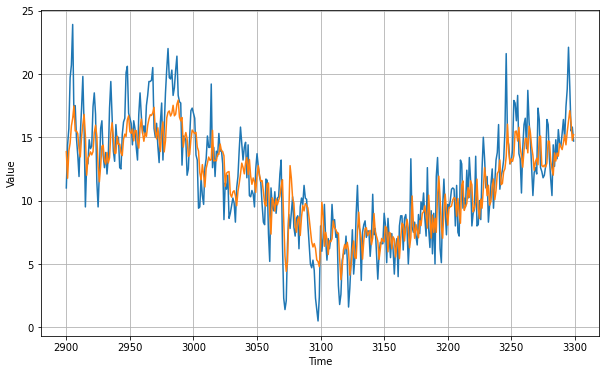

In [37]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, start=400, end=800)
plot_series(time_valid, rnn_forecast, start=400, end=800)

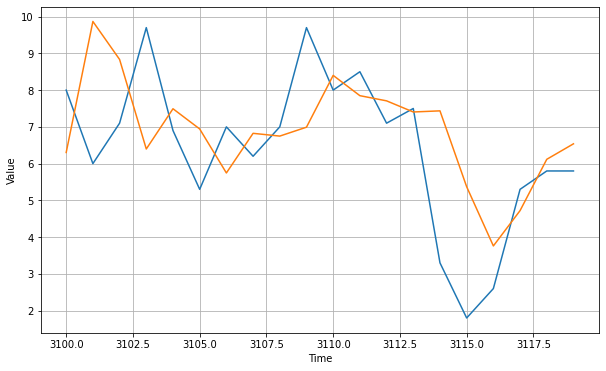

In [40]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, start=600, end=620)
plot_series(time_valid, rnn_forecast, start=600, end=620)

In [45]:
model.save('rnn_model_1', save_format='h5')

In [49]:
model.load_weights('rnn_model_1')

In [50]:
rnn_forecast1 = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast1 = rnn_forecast1[split_time - window_size:-1, -1, 0]